### Preparamos el entorno

In [1]:
!pip install gspread
!pip install gspread-dataframe
!pip install --upgrade gspread
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 1.1 MB/s eta 0:00:00
  Attempting uninstall: gspread
    Found existing installation: gspread 6.0.2
    Uninstalling gspread-6.0.2:
      Successfully uninstalled gspread-6.0.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.5 MB/s eta 0:00:00


In [2]:
! pip install darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.2/52.2 kB 826.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1

In [3]:
# manipulación de data frames y EDA
import pandas as pd
import numpy as np
from datetime import timedelta                                 # diferencia de dos fechas

# visualización
import matplotlib.pyplot as plt
import seaborn as sns

# paquetes estadísticos - modelado de series temporales
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
import statsmodels.api as sm                                   # modelos estadísticos
# !pip install pmdarima
import pmdarima as pm                                          # modelado automático SARIMA
from statsmodels.tsa.arima_model import ARIMA                  # modelo ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX         # modelo SARIMAX
from pylab import rcParams                                     # descomposicion de series temporales
from statsmodels.tsa.stattools import adfuller, kpss           # test Dickey-Fuller y KPSS
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf  # plot the (P)ACF

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [68]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from darts import TimeSeries
from darts.models import ExponentialSmoothing, Prophet, RNNModel
from darts.metrics import rmse
import matplotlib.pyplot as plt


### Importamos y preparamos las series

In [69]:
# URL de la hoja de Google Sheets
sheet_url = "https://docs.google.com/spreadsheets/d/1OVJRz3bjcKnrTl62DdEbvJTrMlDYCLFmRILtqNJgTvs/edit?usp=sharing"

# Convertir la URL a un formato que pandas pueda leer
csv_url = sheet_url.replace('/edit?usp=sharing', '/export?format=csv')

# Leer los datos en un DataFrame de pandas
df_vitalcer = pd.read_csv(csv_url)

In [ ]:
df_vitalcer.shape

(1687, 39)

In [70]:
# Convertir la columna 'fecha' a datetime y establecerla como índice
df_vitalcer['fecha'] = pd.to_datetime(df_vitalcer['fecha'])
df_vitalcer.set_index('fecha', inplace=True)

In [71]:
# Convertir todas las columnas excepto el índice a tipo numérico
for col in df_vitalcer.columns:
    if df_vitalcer[col].dtype == 'object':
        df_vitalcer[col] = df_vitalcer[col].str.replace(',', '.')
        df_vitalcer[col] = pd.to_numeric(df_vitalcer[col], errors='coerce')

In [ ]:
df_vitalcer.dtypes

,0
Monto_deflactado,float64
dieta,int64
RH2M,float64
sube,float64
ripte,float64
indice_salarios,float64
indice_salarios_registrado,float64
indice_salarios_registrado_sector_privado,float64
indice_salarios_registrado_sector_publico,float64
indice_salarios_no_registrado_sector_privado,float64


In [72]:
# Imputar valores nulos en las columnas 'Visitas pagina' y 'Alcance IG' con 0
df_vitalcer['Visitas pagina'].fillna(0, inplace=True)
df_vitalcer['Alcance IG'].fillna(0, inplace=True)

In [73]:
print('Cantidad de NaNs:')
for column in df_vitalcer:
    nans = df_vitalcer[column].isna().sum()
    print(f'\tColumna {column}: {nans}')

Cantidad de NaNs:
	Columna Monto_deflactado: 0
	Columna dieta: 0
	Columna RH2M: 0
	Columna sube: 0
	Columna ripte: 0
	Columna indice_salarios: 0
	Columna indice_salarios_registrado: 0
	Columna indice_salarios_registrado_sector_privado: 0
	Columna indice_salarios_registrado_sector_publico: 0
	Columna indice_salarios_no_registrado_sector_privado: 0
	Columna indice_gran_buenos_aires: 0
	Columna comercio_mayorista_minorista_reparaciones: 0
	Columna Ventas Minoristas: 0
	Columna ventas_precios_corrientes: 0
	Columna ventas_precios_constantes: 0
	Columna ventas_totales_canal_venta: 0
	Columna salon_ventas: 0
	Columna canales_on_line: 0
	Columna ventas_totales_medio_pago: 0
	Columna efectivo: 0
	Columna tarjetas_debito: 0
	Columna tarjetas_credito: 0
	Columna otros_medios: 0
	Columna ventas_totales_grupo_articulos: 0
	Columna subtotal_ventas_alimentos_bebidas: 0
	Columna bebidas: 0
	Columna almacen: 0
	Columna panaderia: 0
	Columna lacteos: 0
	Columna carnes: 0
	Columna verduleria_fruteria: 0

Dado que el dataset puede contener días faltantes (por ejemplo, fines de semana o días festivos en los que no se realizaron ventas), el primer paso es asegurar que los datos estén representados en una frecuencia diaria. Este proceso incluye la creación de un índice diario y el llenado de los días faltantes con un valor de cero, que en este caso representa días sin ventas.

In [21]:
df_time_diffs = df_vitalcer.index.to_series().diff().dt.days
print(df_time_diffs.value_counts())

fecha
1.00    1686
Name: count, dtype: int64


In [74]:
# Resamplea a una frecuencia diaria y llena los días faltantes con 0
df_vitalcer_daily = df_vitalcer.asfreq('D').fillna(0)
print(df_vitalcer_daily)

            Monto_deflactado  dieta  RH2M     sube     ripte  indice_salarios  \
fecha                                                                           
2019-11-15         595695.03     62 66.94  3867.00  49574.33           239.44   
2019-11-16         460448.31     60 75.19  3867.00  49574.33           239.44   
2019-11-17              0.00      0  0.00  3867.00  49574.33           239.44   
2019-11-18              0.00      0  0.00  3867.00  49574.33           239.44   
2019-11-19         606252.48     88 73.75  3867.00  49574.33           239.44   
...                      ...    ...   ...      ...       ...              ...   
2024-06-23              0.00      0  0.00  7952.00 879483.08          4077.32   
2024-06-24         758690.00     64 81.62 29191.00 879483.08          4077.32   
2024-06-25         614865.00     64 85.44 28699.00 879483.08          4077.32   
2024-06-26         765132.00     66 82.25 29018.00 879483.08          4077.32   
2024-06-27         975635.00

In [ ]:
df_time_diffs = df_vitalcer_daily.index.to_series().diff().dt.days
print(df_time_diffs.value_counts())

fecha
1.00    1686
Name: count, dtype: int64


In [26]:
df_vitalcer_daily.head()

,Monto_deflactado,dieta,RH2M,sube,ripte,indice_salarios,indice_salarios_registrado,indice_salarios_registrado_sector_privado,indice_salarios_registrado_sector_publico,indice_salarios_no_registrado_sector_privado,...,lacteos,carnes,verduleria_fruteria,alimentos_preparados_rotiseria,articulos_limpieza_perfumeria,indumentaria_calzado_textiles_hogar,electronicos_articulos_hogar,otros,Visitas pagina,Alcance IG
fecha,,,,,,,,,,,,,,,,,,,,,
2019-11-15,595695.03,62,66.94,3867.00,49574.33,239.44,243.40,246.54,238.13,223.54,...,7985919.66,8877286.12,2838731.67,883049.92,11316019.27,2197595.47,4638017.91,7726583.68,0.00,0.00
2019-11-16,460448.31,60,75.19,3867.00,49574.33,239.44,243.40,246.54,238.13,223.54,...,7985919.66,8877286.12,2838731.67,883049.92,11316019.27,2197595.47,4638017.91,7726583.68,0.00,0.00
2019-11-17,0.00,0,0.00,3867.00,49574.33,239.44,243.40,246.54,238.13,223.54,...,7985919.66,8877286.12,2838731.67,883049.92,11316019.27,2197595.47,4638017.91,7726583.68,0.00,0.00
2019-11-18,0.00,0,0.00,3867.00,49574.33,239.44,243.40,246.54,238.13,223.54,...,7985919.66,8877286.12,2838731.67,883049.92,11316019.27,2197595.47,4638017.91,7726583.68,0.00,0.00
2019-11-19,606252.48,88,73.75,3867.00,49574.33,239.44,243.40,246.54,238.13,223.54,...,7985919.66,8877286.12,2838731.67,883049.92,11316019.27,2197595.47,4638017.91,7726583.68,0.00,0.00


### Modelado

#### Redes Neuronales

##### Modelo univariado-unistep LSTM

División de los datos: Sets de entrenamiento, validación y prueba

In [ ]:
def train_val_test_split(serie, tr_size=0.8, vl_size=0.1, ts_size=0.1 ):
    # Definir número de datos en cada subserie
    N = serie.shape[0]
    Ntrain = int(tr_size*N)  # Número de datos de entrenamiento
    Nval = int(vl_size*N)    # Número de datos de validación
    Ntst = N - Ntrain - Nval # Número de datos de prueba

    # Realizar partición
    train = serie[0:Ntrain]
    val = serie[Ntrain:Ntrain+Nval]
    test = serie[Ntrain+Nval:]

    return train, val, test

In [ ]:
tr, vl, ts = train_val_test_split(df_vitalcer_daily['Monto_deflactado'])

# Imprimir en pantalla el tamaño de cada subset
print(f'Tamaño set de entrenamiento: {tr.shape}')
print(f'Tamaño set de validación: {vl.shape}')
print(f'Tamaño set de prueba: {ts.shape}')

Tamaño set de entrenamiento: (1349,)
Tamaño set de validación: (168,)
Tamaño set de prueba: (170,)


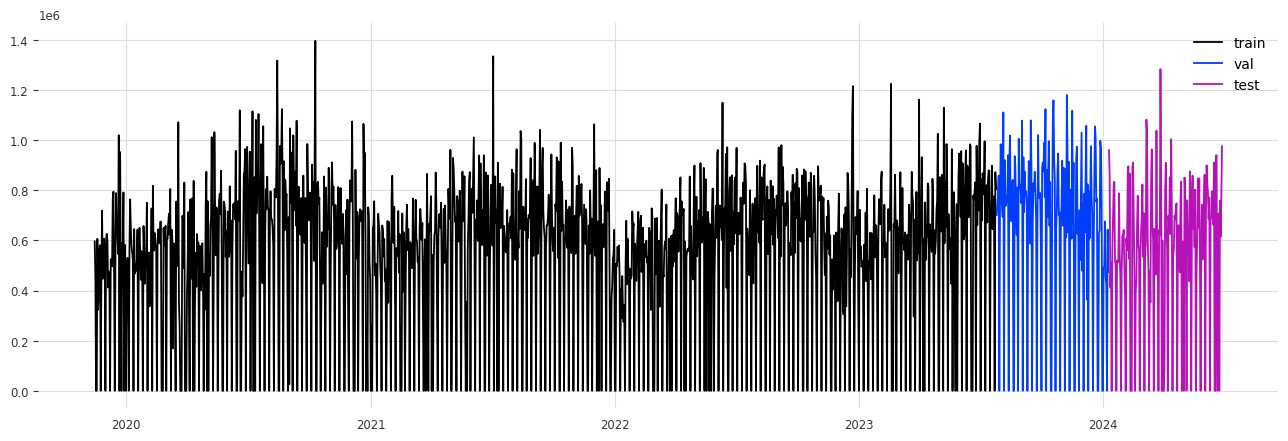

In [ ]:
fig, ax = plt.subplots(figsize=(16,5))
ax.plot(tr,label="train")
ax.plot(vl,label="val")
ax.plot(ts,label="test")
plt.legend();

El gráfico se ve de esta manera porque se reemplazo por 0 los días que no hubo facturación. Ya que corresponden a días donde el local no trabaja.

**Adecuación para una red LSTM**

Una vez que los datos están divididos, se deben transformar en secuencias que la red LSTM pueda utilizar. En este contexto, se crea una secuencia de 14 días de datos para predecir el monto de facturación del día siguiente. Esta es una estructura común para problemas de series temporales, donde se utiliza una ventana de tiempo para hacer predicciones futuras.

In [ ]:
def crear_dataset_supervisado(array, input_length, output_length):

    # Inicialización
    X, Y = [], []    # Listados que contendrán los datos de entrada y salida del modelo
    shape = array.shape
    if len(shape)==1: # Si tenemos sólo una serie (univariado)
        fils, cols = array.shape[0], 1
        array = array.reshape(fils,cols)
    else: # Multivariado
        fils, cols = array.shape

    # Generar los arreglos (utilizando ventanas deslizantes de longitud input_length)
    for i in range(fils-input_length-output_length):
        X.append(array[i:i+INPUT_LENGTH,0:cols])
        Y.append(array[i+input_length:i+input_length+output_length,-1].reshape(output_length,1))

    # Convertir listas a arreglos de NumPy
    X = np.array(X)
    Y = np.array(Y)

    return X, Y


In [ ]:
# Definición de los hiperparámetros INPUT_LENGTH y OUTPUT_LENGTH
INPUT_LENGTH = 14
OUTPUT_LENGTH = 1
# Datasets supervisados para entrenamiento (x_tr, y_tr), validación
# (x_vl, y_vl) y prueba (x_ts, y_ts)
x_tr, y_tr = crear_dataset_supervisado(tr.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_vl, y_vl = crear_dataset_supervisado(vl.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_ts, y_ts = crear_dataset_supervisado(ts.values, INPUT_LENGTH, OUTPUT_LENGTH)

**Redimensionamiento de Datos**

Finalmente, los datos deben ser redimensionados para cumplir con los requisitos de entrada de la red LSTM. En el caso de una LSTM univariada, la entrada X tiene la forma (batches, input_length, features) y la salida Y tiene la forma (batches, output_length, features)

In [ ]:
print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - x_tr: {x_tr.shape}, y_tr: {y_tr.shape}')
print(f'Set de validación - x_vl: {x_vl.shape}, y_vl: {y_vl.shape}')
print(f'Set de prueba - x_ts: {x_ts.shape}, y_ts: {y_ts.shape}')

Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr: (1334, 14, 1), y_tr: (1334, 1, 1)
Set de validación - x_vl: (153, 14, 1), y_vl: (153, 1, 1)
Set de prueba - x_ts: (155, 14, 1), y_ts: (155, 1, 1)


**Escalamiento de los datos**

Es recomendable, al utilizar modelos de deep learning, asegurar que las variables que alimentan el modelo se encuentran en el mismo rango de valores.

Rango de Valores Consistente: La LSTM y otros modelos de redes neuronales generalmente funcionan mejor cuando las características están en un rango similar. Los datos sin escalar tienen un rango muy grande, mientras que los datos escalados están en un rango de
[
−
1
,
1
]
[−1,1], lo cual es más adecuado para las redes neuronales.

Mejora de la Convergencia: El escalamiento mejora la convergencia durante el entrenamiento al evitar problemas relacionados con la magnitud de los gradientes durante la retropropagación.

Proporcionalidad: La LSTM asume que los datos están en un rango comparable para todas las características. Sin escalamiento, la red puede dar más peso a las características con valores más grandes.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
def escalar_dataset(data_input):
    NFEATS = data_input['x_tr'].shape[2]

    # Generar listado con "scalers"
    scalers = [MinMaxScaler(feature_range=(-1,1)) for i in range(NFEATS)]

    # Arreglos que contendrán los datasets escalados (Se crean arreglos vacíos con las mismas dimensiones que los conjuntos de datos originales para almacenar los datos escalados)
    x_tr_s = np.zeros(data_input['x_tr'].shape)
    x_vl_s = np.zeros(data_input['x_vl'].shape)
    x_ts_s = np.zeros(data_input['x_ts'].shape)
    y_tr_s = np.zeros(data_input['y_tr'].shape)
    y_vl_s = np.zeros(data_input['y_vl'].shape)
    y_ts_s = np.zeros(data_input['y_ts'].shape)

    # Escalamiento: se usarán los min/max del set de entrenamiento para
    # escalar la totalidad de los datasets

    # Escalamiento Xs (aca es una sola feature, pero en un multivariado ya nos quedará a estructura)
    for i in range(NFEATS):
        x_tr_s[:,:,i] = scalers[i].fit_transform(x_tr[:,:,i]) #ajustamos a los datos de entrenamiento
        x_vl_s[:,:,i] = scalers[i].transform(x_vl[:,:,i]) #transformamos con el ajuste a val y a test tomando el rango del set de entrenamiento
        x_ts_s[:,:,i] = scalers[i].transform(x_ts[:,:,i])

    # Escalamiento Ys (Se asume que las etiquetas se encuentran en la última columna de los conjuntos de datos...ademas, en este caso es una sola columna)
    y_tr_s[:,:,0] = scalers[-1].fit_transform(y_tr[:,:,0])
    y_vl_s[:,:,0] = scalers[-1].transform(y_vl[:,:,0])
    y_ts_s[:,:,0] = scalers[-1].transform(y_ts[:,:,0])

    # Conformar ` de salida
    data_scaled = {
        'x_tr_s': x_tr_s, 'y_tr_s': y_tr_s,
        'x_vl_s': x_vl_s, 'y_vl_s': y_vl_s,
        'x_ts_s': x_ts_s, 'y_ts_s': y_ts_s,
    }

    return data_scaled, scalers[0] #útil para realizar la inversión de escalamiento

In [ ]:
data_in = {
    'x_tr': x_tr, 'y_tr': y_tr,
    'x_vl': x_vl, 'y_vl': y_vl,
    'x_ts': x_ts, 'y_ts': y_ts,
}

In [ ]:
data_s, scaler = escalar_dataset(data_in)

In [ ]:
x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
x_vl_s, y_vl_s = data_s['x_vl_s'], data_s['y_vl_s']
x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

**Creación de la Red LSTM**

In [ ]:
import tensorflow as tf  # Importar TensorFlow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import RMSprop  # Asegúrate de importar RMSprop

In [ ]:
tf.random.set_seed(123) #para garantizar la reproducibidad del entrenamiento

In [ ]:
tf.config.experimental.enable_op_determinism() #realizaremos el entrenamiento usando la GPU proporcionada por Google Colab

En el contexto de una red LSTM, N_UNITS se refiere al número de neuronas en la capa LSTM. Cada unidad LSTM puede mantener información en su memoria a corto y largo plazo, y el número de unidades determina la capacidad de la red para aprender patrones complejos.

Más Unidades: Permite al modelo capturar patrones más complejos, pero también aumenta el riesgo de sobreajuste (overfitting) y el tiempo de entrenamiento. Menos Unidades: Reduce el riesgo de sobreajuste y acelera el entrenamiento, pero puede ser insuficiente para capturar patrones complejos en los dato

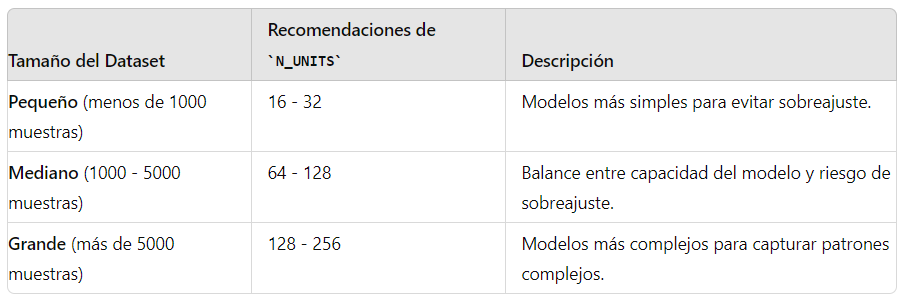

In [ ]:
N_UNITS = 128 #número de unidades del modelo (que corresponde al tamaño del estado oculto y a la celda de memoria de la Red LSTM.
#hiperparámetro del modelo a afinar

In [ ]:
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2]) #cada uno de los datos de entrada será un arreglo de tamaño 14 x 1 (feature).

In [ ]:
modelo = Sequential() #caja vacía a la cual se le adicionaran de manera secuencial los elementos
modelo.add(LSTM(N_UNITS, input_shape=INPUT_SHAPE))
modelo.add(Dense(OUTPUT_LENGTH, activation='linear'))

**Compilación del modelo**

Definimos la función de error a usar durante el entrenamiento así como el optimizador. Es decir, definimos que algoritmo matematico utiizaremos para reducir esa perdida a medida que vanzan las iteraciones.

In [ ]:
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

In [ ]:
optimizador = RMSprop(learning_rate=5e-5)

In [ ]:
modelo.compile(
    optimizer = optimizador,
    loss = root_mean_squared_error,
)

**Entrenamiento del modelo**

EPOCHS: Número de veces que el modelo ve todo el dataset durante el entrenamiento. Un número mayor de épocas puede mejorar el ajuste del modelo, pero también puede llevar a sobreajuste si se entrena demasiado.

BATCH_SIZE: Número de ejemplos usados para actualizar los pesos en cada iteración. Un tamaño de lote mayor puede acelerar el entrenamiento pero también puede aumentar el uso de memoria.

In [ ]:
EPOCHS = 80 #iteraciones de entrenamiento
BATCH_SIZE = 256 #tamaño del lote (es decir, 256 datos de entrenamiento en cada iteración)

In [ ]:
historia = modelo.fit(
    x = x_tr_s,
    y = y_tr_s,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = (x_vl_s, y_vl_s),
    verbose=2 #vemos como evoluciona el entrenamiento
)

Epoch 1/80
6/6 - 2s - 338ms/step - loss: 0.4716 - val_loss: 0.4855
Epoch 2/80
6/6 - 1s - 182ms/step - loss: 0.4661 - val_loss: 0.4852
Epoch 3/80
6/6 - 1s - 112ms/step - loss: 0.4619 - val_loss: 0.4849
Epoch 4/80
6/6 - 1s - 83ms/step - loss: 0.4583 - val_loss: 0.4848
Epoch 5/80
6/6 - 0s - 83ms/step - loss: 0.4550 - val_loss: 0.4846
Epoch 6/80
6/6 - 1s - 108ms/step - loss: 0.4519 - val_loss: 0.4845
Epoch 7/80
6/6 - 0s - 71ms/step - loss: 0.4490 - val_loss: 0.4844
Epoch 8/80
6/6 - 0s - 50ms/step - loss: 0.4462 - val_loss: 0.4844
Epoch 9/80
6/6 - 0s - 48ms/step - loss: 0.4436 - val_loss: 0.4844
Epoch 10/80
6/6 - 0s - 53ms/step - loss: 0.4412 - val_loss: 0.4845
Epoch 11/80
6/6 - 0s - 49ms/step - loss: 0.4389 - val_loss: 0.4846
Epoch 12/80
6/6 - 0s - 49ms/step - loss: 0.4369 - val_loss: 0.4847
Epoch 13/80
6/6 - 0s - 51ms/step - loss: 0.4350 - val_loss: 0.4848
Epoch 14/80
6/6 - 0s - 49ms/step - loss: 0.4334 - val_loss: 0.4850
Epoch 15/80
6/6 - 0s - 49ms/step - loss: 0.4320 - val_loss: 0.4851


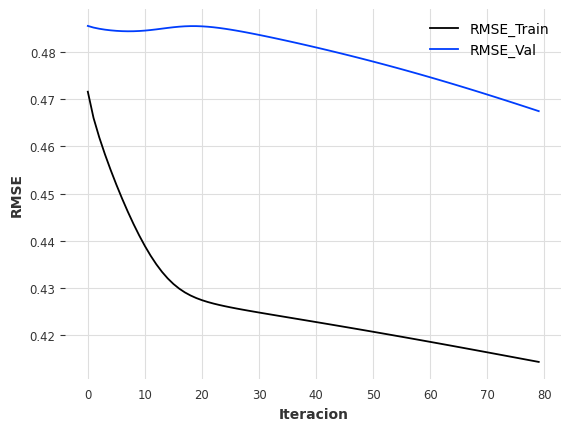

In [ ]:
plt.plot(historia.history['loss'],label='RMSE_Train')
plt.plot(historia.history['val_loss'],label='RMSE_Val')
plt.xlabel('Iteracion')
plt.ylabel('RMSE')
plt.legend();

**Desempeño del Modelo**

In [ ]:
rmse_tr = modelo.evaluate(x=x_tr_s, y=y_tr_s, verbose=0)
rmse_vl = modelo.evaluate(x=x_vl_s, y=y_vl_s, verbose=0)
rmse_ts = modelo.evaluate(x=x_ts_s, y=y_ts_s, verbose=0)
print('Comparativo desempeños:')
print(f'  RMSE train:\t {rmse_tr:.3f}')
print(f'  RMSE val:\t {rmse_vl:.3f}')
print(f'  RMSE test:\t {rmse_ts:.3f}')

Comparativo desempeños:
  RMSE train:	 0.412
  RMSE val:	 0.467
  RMSE test:	 0.427


Train vs. Val	0.412 vs. 0.467	El RMSE en entrenamiento es menor que en validación, lo que puede indicar sobreajuste.
Train vs. Test	0.412 vs. 0.427	El RMSE en prueba es cercano al de validación, lo que sugiere una buena capacidad de generalización.
Val vs. Test	0.467 vs. 0.427	La diferencia pequeña indica que el modelo generaliza bastante bien a nuevos datos, aunque la validación muestra un ligero mayor error.

**Predicciones (forecasting) con el modelo entrenado**

In [ ]:
def predecir(x, model, scaler):
    # Calcular predicción escalada en el rango de -1 a 1
    y_pred_s = model.predict(x,verbose=0)

    # Llevar la predicción a la escala original
    y_pred = scaler.inverse_transform(y_pred_s)

    return y_pred.flatten()


In [ ]:
y_ts_pred = predecir(x_ts_s, modelo, scaler)

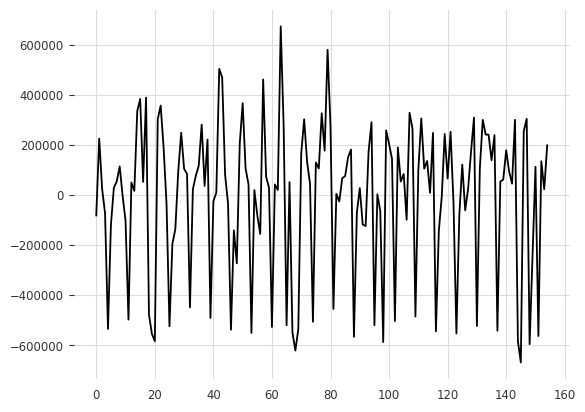

In [ ]:
N = len(y_ts_pred)    # Número de predicciones (tamaño del set de prueba)
ndato = np.linspace(1,N,N)

# Cálculo de errores simples
errores = y_ts.flatten()-y_ts_pred
plt.plot(errores);

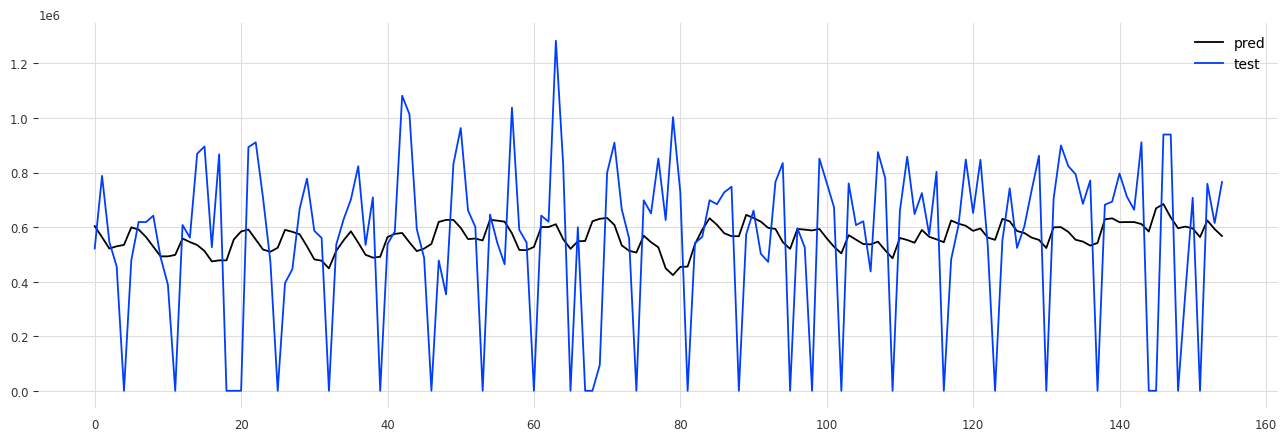

In [ ]:
fig, ax = plt.subplots(figsize=(16,5))
ax.plot(y_ts_pred,label="pred")
ax.plot(y_ts.flatten(),label="test")
plt.legend();

Hay varias técnicas para mejorar el modelo:

Regularización Adicional:
Dropout: Aumentar la tasa de dropout para reducir el sobreajuste. Ejemplo: modelo.add(Dropout(0.4))
Regularización L2: Añadir regularización L2 en las capas LSTM. Ejemplo: LSTM(N_UNITS, activation='relu', kernel_regularizer=l2(0.01))

Reducir la Complejidad del Modelo:
Menos Unidades: Reducir el número de unidades en las capas LSTM. Ejemplo: N_UNITS = 64
Menos Capas: Reducir el número de capas LSTM. Ejemplo: modelo.add(LSTM(N_UNITS, return_sequences=True))
Ajustar el Tasa de Aprendizaje:

Learning Rate: Ajustar la tasa de aprendizaje del optimizador. Ejemplo: RMSprop(learning_rate=1e-4)

Early Stopping:
Detener Entrenamiento: Utiliza early stopping para detener el entrenamiento cuando la validación no mejora.

In [ ]:
# Rango original
min_original = 0
max_original = 1396256.756

# Desnormalización del RMSE
rmse_tr_original = rmse_tr * (max_original / 2) + (max_original / 2)
rmse_vl_original = rmse_vl * (max_original / 2) + (max_original / 2)
rmse_ts_original = rmse_ts * (max_original / 2) + (max_original / 2)

print('Comparativo desempeños:')
print(f'  RMSE train (Original Scale):\t {rmse_tr_original:.2f}')
print(f'  RMSE val (Original Scale):\t {rmse_vl_original:.2f}')
print(f'  RMSE test (Original Scale):\t {rmse_ts_original:.2f}')


Comparativo desempeños:
  RMSE train (Original Scale):	 985427.14
  RMSE val (Original Scale):	 1024056.28
  RMSE test (Original Scale):	 996455.22


##### Modelos Multivariantes

In [ ]:
! pip install neuralforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.4/249.4 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from neuralforecast.core import NeuralForecast
from neuralforecast.models import NHITS, PatchTST, BiTCN

In [ ]:
df_vitalcer_daily.head()

,Monto_deflactado,dieta,RH2M,sube,ripte,indice_salarios,indice_salarios_registrado,indice_salarios_registrado_sector_privado,indice_salarios_registrado_sector_publico,indice_salarios_no_registrado_sector_privado,...,lacteos,carnes,verduleria_fruteria,alimentos_preparados_rotiseria,articulos_limpieza_perfumeria,indumentaria_calzado_textiles_hogar,electronicos_articulos_hogar,otros,Visitas pagina,Alcance IG
fecha,,,,,,,,,,,,,,,,,,,,,
2019-11-15,595695.03,62,66.94,3867.00,49574.33,239.44,243.40,246.54,238.13,223.54,...,7985919.66,8877286.12,2838731.67,883049.92,11316019.27,2197595.47,4638017.91,7726583.68,0.00,0.00
2019-11-16,460448.31,60,75.19,3867.00,49574.33,239.44,243.40,246.54,238.13,223.54,...,7985919.66,8877286.12,2838731.67,883049.92,11316019.27,2197595.47,4638017.91,7726583.68,0.00,0.00
2019-11-17,0.00,0,0.00,3867.00,49574.33,239.44,243.40,246.54,238.13,223.54,...,7985919.66,8877286.12,2838731.67,883049.92,11316019.27,2197595.47,4638017.91,7726583.68,0.00,0.00
2019-11-18,0.00,0,0.00,3867.00,49574.33,239.44,243.40,246.54,238.13,223.54,...,7985919.66,8877286.12,2838731.67,883049.92,11316019.27,2197595.47,4638017.91,7726583.68,0.00,0.00
2019-11-19,606252.48,88,73.75,3867.00,49574.33,239.44,243.40,246.54,238.13,223.54,...,7985919.66,8877286.12,2838731.67,883049.92,11316019.27,2197595.47,4638017.91,7726583.68,0.00,0.00


In [24]:
df_vitalcer_daily.rename(columns={'Monto_deflactado': 'y'}, inplace=True)

In [25]:
df_vitalcer_daily['no_laboral'] = (df_vitalcer_daily['y'] == 0).astype(int)

In [ ]:
display(df_vitalcer_daily)

,y,dieta,RH2M,sube,ripte,indice_salarios,indice_salarios_registrado,indice_salarios_registrado_sector_privado,indice_salarios_registrado_sector_publico,indice_salarios_no_registrado_sector_privado,...,carnes,verduleria_fruteria,alimentos_preparados_rotiseria,articulos_limpieza_perfumeria,indumentaria_calzado_textiles_hogar,electronicos_articulos_hogar,otros,Visitas pagina,Alcance IG,no_laboral
fecha,,,,,,,,,,,,,,,,,,,,,
2019-11-15,595695.03,62,66.94,3867.00,49574.33,239.44,243.40,246.54,238.13,223.54,...,8877286.12,2838731.67,883049.92,11316019.27,2197595.47,4638017.91,7726583.68,0.00,0.00,0
2019-11-16,460448.31,60,75.19,3867.00,49574.33,239.44,243.40,246.54,238.13,223.54,...,8877286.12,2838731.67,883049.92,11316019.27,2197595.47,4638017.91,7726583.68,0.00,0.00,0
2019-11-17,0.00,0,0.00,3867.00,49574.33,239.44,243.40,246.54,238.13,223.54,...,8877286.12,2838731.67,883049.92,11316019.27,2197595.47,4638017.91,7726583.68,0.00,0.00,1
2019-11-18,0.00,0,0.00,3867.00,49574.33,239.44,243.40,246.54,238.13,223.54,...,8877286.12,2838731.67,883049.92,11316019.27,2197595.47,4638017.91,7726583.68,0.00,0.00,1
2019-11-19,606252.48,88,73.75,3867.00,49574.33,239.44,243.40,246.54,238.13,223.54,...,8877286.12,2838731.67,883049.92,11316019.27,2197595.47,4638017.91,7726583.68,0.00,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-23,0.00,0,0.00,7952.00,879483.08,4077.32,4490.03,4807.34,3957.89,2419.24,...,153950342.70,60571949.32,13628091.52,207457595.60,34292093.85,65096403.31,85587417.60,10.00,4.00,1
2024-06-24,758690.00,64,81.62,29191.00,879483.08,4077.32,4490.03,4807.34,3957.89,2419.24,...,153950342.70,60571949.32,13628091.52,207457595.60,34292093.85,65096403.31,85587417.60,26.00,12.00,0
2024-06-25,614865.00,64,85.44,28699.00,879483.08,4077.32,4490.03,4807.34,3957.89,2419.24,...,153950342.70,60571949.32,13628091.52,207457595.60,34292093.85,65096403.31,85587417.60,25.00,15.00,0


Para usar este tipo de redes es necesario que la fecha se llame ds y tenga formato datetime, exista la columna unique_id

In [26]:
df_vitalcer_daily.reset_index(inplace=True)  # Conviértelo en una columna llamada 'index'

# Renombra la columna 'index' a 'ds'
df_vitalcer_daily.rename(columns={'fecha': 'ds'}, inplace=True)


In [ ]:
df_vitalcer_daily['unique_id'] = 0

In [ ]:
df_vitalcer_daily.shape

(1687, 39)

In [ ]:
train = df_vitalcer_daily[:-28]
test = df_vitalcer_daily[-28:]

print(train.shape, test.shape)

(1659, 41) (28, 41)


In [ ]:
# Create a future dataframe with values of exogenous variables

future_df = test.drop(['y'], axis=1)
future_df.head()

,ds,dieta,RH2M,sube,ripte,indice_salarios,indice_salarios_registrado,indice_salarios_registrado_sector_privado,indice_salarios_registrado_sector_publico,indice_salarios_no_registrado_sector_privado,...,verduleria_fruteria,alimentos_preparados_rotiseria,articulos_limpieza_perfumeria,indumentaria_calzado_textiles_hogar,electronicos_articulos_hogar,otros,Visitas pagina,Alcance IG,no_laboral,unique_id
1659,2024-05-31,50,83.56,28811.00,879483.08,4077.32,4490.03,4807.34,3957.89,2419.24,...,60571949.32,13628091.52,207457595.60,34292093.85,65096403.31,85587417.60,24.00,14.00,0,0
1660,2024-06-01,39,85.75,16221.00,879483.08,4077.32,4490.03,4807.34,3957.89,2419.24,...,60571949.32,13628091.52,207457595.60,34292093.85,65096403.31,85587417.60,23.00,13.00,0,0
1661,2024-06-02,0,0.00,7048.00,879483.08,4077.32,4490.03,4807.34,3957.89,2419.24,...,60571949.32,13628091.52,207457595.60,34292093.85,65096403.31,85587417.60,19.00,1.00,1,0
1662,2024-06-03,72,82.94,28338.00,879483.08,4077.32,4490.03,4807.34,3957.89,2419.24,...,60571949.32,13628091.52,207457595.60,34292093.85,65096403.31,85587417.60,42.00,11.00,0,0
1663,2024-06-04,71,80.19,27581.00,879483.08,4077.32,4490.03,4807.34,3957.89,2419.24,...,60571949.32,13628091.52,207457595.60,34292093.85,65096403.31,85587417.60,36.00,5.00,0,0


In [ ]:
horizon = len(test)

models = [
    NHITS(
        h=horizon,
        input_size = 5*horizon,
        futr_exog_list=['dieta', 'RH2M', 'sube', 'ripte', 'indice_salarios',
                                  'indice_salarios_registrado', 'indice_salarios_registrado_sector_privado',
                                  'indice_salarios_registrado_sector_publico', 'indice_salarios_no_registrado_sector_privado',
                                  'indice_gran_buenos_aires', 'comercio_mayorista_minorista_reparaciones', 'Ventas Minoristas',
                                  'ventas_precios_corrientes', 'ventas_precios_constantes', 'ventas_totales_canal_venta', 'salon_ventas',
                                  'canales_on_line', 'ventas_totales_medio_pago', 'efectivo', 'tarjetas_debito', 'tarjetas_credito',
                                  'otros_medios', 'ventas_totales_grupo_articulos', 'subtotal_ventas_alimentos_bebidas', 'bebidas',
                                  'almacen', 'panaderia', 'lacteos', 'carnes', 'verduleria_fruteria', 'alimentos_preparados_rotiseria',
                                  'articulos_limpieza_perfumeria', 'indumentaria_calzado_textiles_hogar', 'electronicos_articulos_hogar', 'otros','Visitas pagina','Alcance IG','no_laboral'],
        hist_exog_list=['dieta', 'RH2M', 'sube', 'ripte', 'indice_salarios',
                                  'indice_salarios_registrado', 'indice_salarios_registrado_sector_privado',
                                  'indice_salarios_registrado_sector_publico', 'indice_salarios_no_registrado_sector_privado',
                                  'indice_gran_buenos_aires', 'comercio_mayorista_minorista_reparaciones', 'Ventas Minoristas',
                                  'ventas_precios_corrientes', 'ventas_precios_constantes', 'ventas_totales_canal_venta', 'salon_ventas',
                                  'canales_on_line', 'ventas_totales_medio_pago', 'efectivo', 'tarjetas_debito', 'tarjetas_credito',
                                  'otros_medios', 'ventas_totales_grupo_articulos', 'subtotal_ventas_alimentos_bebidas', 'bebidas',
                                  'almacen', 'panaderia', 'lacteos', 'carnes', 'verduleria_fruteria', 'alimentos_preparados_rotiseria',
                                  'articulos_limpieza_perfumeria', 'indumentaria_calzado_textiles_hogar', 'electronicos_articulos_hogar', 'otros','Visitas pagina','Alcance IG','no_laboral'],
        scaler_type='robust'),
    BiTCN(
        h=horizon,
        input_size=5*horizon,
        futr_exog_list=['dieta', 'RH2M', 'sube', 'ripte', 'indice_salarios',
                                  'indice_salarios_registrado', 'indice_salarios_registrado_sector_privado',
                                  'indice_salarios_registrado_sector_publico', 'indice_salarios_no_registrado_sector_privado',
                                  'indice_gran_buenos_aires', 'comercio_mayorista_minorista_reparaciones', 'Ventas Minoristas',
                                  'ventas_precios_corrientes', 'ventas_precios_constantes', 'ventas_totales_canal_venta', 'salon_ventas',
                                  'canales_on_line', 'ventas_totales_medio_pago', 'efectivo', 'tarjetas_debito', 'tarjetas_credito',
                                  'otros_medios', 'ventas_totales_grupo_articulos', 'subtotal_ventas_alimentos_bebidas', 'bebidas',
                                  'almacen', 'panaderia', 'lacteos', 'carnes', 'verduleria_fruteria', 'alimentos_preparados_rotiseria',
                                  'articulos_limpieza_perfumeria', 'indumentaria_calzado_textiles_hogar', 'electronicos_articulos_hogar', 'otros','Visitas pagina','Alcance IG','no_laboral'],
        hist_exog_list=['dieta', 'RH2M', 'sube', 'ripte', 'indice_salarios',
                                  'indice_salarios_registrado', 'indice_salarios_registrado_sector_privado',
                                  'indice_salarios_registrado_sector_publico', 'indice_salarios_no_registrado_sector_privado',
                                  'indice_gran_buenos_aires', 'comercio_mayorista_minorista_reparaciones', 'Ventas Minoristas',
                                  'ventas_precios_corrientes', 'ventas_precios_constantes', 'ventas_totales_canal_venta', 'salon_ventas',
                                  'canales_on_line', 'ventas_totales_medio_pago', 'efectivo', 'tarjetas_debito', 'tarjetas_credito',
                                  'otros_medios', 'ventas_totales_grupo_articulos', 'subtotal_ventas_alimentos_bebidas', 'bebidas',
                                  'almacen', 'panaderia', 'lacteos', 'carnes', 'verduleria_fruteria', 'alimentos_preparados_rotiseria',
                                  'articulos_limpieza_perfumeria', 'indumentaria_calzado_textiles_hogar', 'electronicos_articulos_hogar', 'otros','Visitas pagina','Alcance IG','no_laboral'],
        scaler_type='robust'),
    PatchTST(
        h=horizon,
        input_size=2*horizon,
        encoder_layers=3,
        hidden_size=128,
        linear_hidden_size=128,
        patch_len=4,
        stride=1,
        revin=True,
        max_steps=1000
    )
]

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1


In [ ]:
nf = NeuralForecast(models=models, freq='D')
nf.fit(df=train)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 14.7 M | train
-------------------------------------------------------
14.7 M    Trainable params
0         Non-trainable params
14.7 M    Total params
58.937    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | MAE           | 0      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 1.2 K  | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 8.6 K  | train
6  | lin_futr      | Linear        | 624    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 8.6 K  | train
9  | drop_temporal | Dropout       | 0    

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MAE               | 0      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 499 K  | train
-----------------------------------------------------------
499 K     Trainable params
3         Non-trainable params
499 K     Total params
1.999     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


In [ ]:
preds_df = nf.predict(futr_df=future_df)
preds_df.head()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

,ds,NHITS,BiTCN,PatchTST
unique_id,,,,
0,2024-05-31,595885.38,714804.88,644664.94
0,2024-06-01,693066.75,589745.56,773308.62
0,2024-06-02,-241025.31,17509.50,-7894.31
0,2024-06-03,503014.66,539539.88,597502.19
0,2024-06-04,569903.88,623202.31,740068.38


In [ ]:
test_df = pd.merge(test, preds_df, 'left', 'ds')
test_df

,ds,y,dieta,RH2M,sube,ripte,indice_salarios,indice_salarios_registrado,indice_salarios_registrado_sector_privado,indice_salarios_registrado_sector_publico,...,indumentaria_calzado_textiles_hogar,electronicos_articulos_hogar,otros,Visitas pagina,Alcance IG,no_laboral,unique_id,NHITS,BiTCN,PatchTST
0,2024-05-31,735305.00,50,83.56,28811.00,879483.08,4077.32,4490.03,4807.34,3957.89,...,34292093.85,65096403.31,85587417.60,24.00,14.00,0,0,595885.38,714804.88,644664.94
1,2024-06-01,861440.00,39,85.75,16221.00,879483.08,4077.32,4490.03,4807.34,3957.89,...,34292093.85,65096403.31,85587417.60,23.00,13.00,0,0,693066.75,589745.56,773308.62
2,2024-06-02,0.00,0,0.00,7048.00,879483.08,4077.32,4490.03,4807.34,3957.89,...,34292093.85,65096403.31,85587417.60,19.00,1.00,1,0,-241025.31,17509.50,-7894.31
3,2024-06-03,704910.00,72,82.94,28338.00,879483.08,4077.32,4490.03,4807.34,3957.89,...,34292093.85,65096403.31,85587417.60,42.00,11.00,0,0,503014.66,539539.88,597502.19
4,2024-06-04,899240.00,71,80.19,27581.00,879483.08,4077.32,4490.03,4807.34,3957.89,...,34292093.85,65096403.31,85587417.60,36.00,5.00,0,0,569903.88,623202.31,740068.38
5,2024-06-05,823515.00,74,87.56,28560.00,879483.08,4077.32,4490.03,4807.34,3957.89,...,34292093.85,65096403.31,85587417.60,39.00,15.00,0,0,491245.50,618329.75,587499.62
6,2024-06-06,793685.00,66,87.50,28785.00,879483.08,4077.32,4490.03,4807.34,3957.89,...,34292093.85,65096403.31,85587417.60,38.00,11.00,0,0,451669.62,629736.75,635708.25
7,2024-06-07,685195.00,69,91.31,30049.00,879483.08,4077.32,4490.03,4807.34,3957.89,...,34292093.85,65096403.31,85587417.60,33.00,4.00,0,0,564365.25,687455.00,644158.94
8,2024-06-08,770660.00,75,94.56,17997.00,879483.08,4077.32,4490.03,4807.34,3957.89,...,34292093.85,65096403.31,85587417.60,31.00,2.00,0,0,793306.00,566194.19,707147.00
9,2024-06-09,0.00,0,0.00,8638.00,879483.08,4077.32,4490.03,4807.34,3957.89,...,34292093.85,65096403.31,85587417.60,23.00,5.00,1,0,-134331.62,-18515.69,-29.69


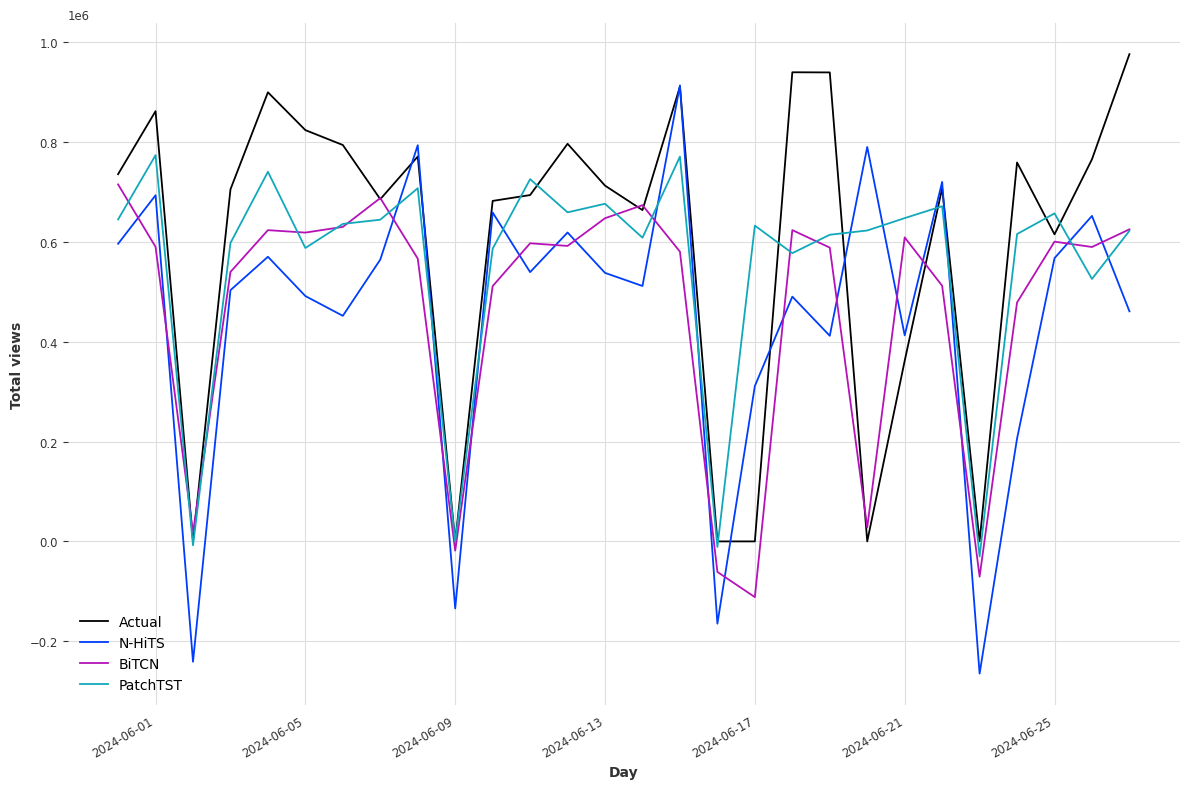

In [ ]:
# published_dates = test_df[test_df['dieta'] == 1]
# holidays = test_df[test_df['RH2M'] == 1]

fig, ax = plt.subplots(figsize=(12,8))

ax.plot(test_df['ds'], test_df['y'], label='Actual')
ax.plot(test_df['ds'], test_df['NHITS'], label='N-HiTS')
ax.plot(test_df['ds'], test_df['BiTCN'], label='BiTCN')
ax.plot(test_df['ds'], test_df['PatchTST'], label='PatchTST')
# ax.scatter(published_dates['ds'], published_dates['y'], marker='o', color='red')
# ax.scatter(holidays['ds'], holidays['y'], marker='x', color='green')
ax.set_xlabel('Day')
ax.set_ylabel('Total views')
ax.legend(loc='best')

fig.autofmt_xdate()


plt.tight_layout()

In [ ]:
from utilsforecast.losses import mae, smape, rmse  # Asegúrate de importar rmse si está disponible
from utilsforecast.evaluation import evaluate

# Evaluar modelos incluyendo el RMSE
evaluation = evaluate(
    test_df,
    metrics=[mae, smape, rmse],  # Agregar rmse a las métricas
    models=["NHITS", "BiTCN", "PatchTST"],
    target_col="y",
)

# Eliminar la columna 'unique_id' y configurar el índice
evaluation = evaluation.drop(['unique_id'], axis=1)
evaluation = evaluation.set_index('metric')

# Resaltar el valor mínimo en cada fila
evaluation.style.highlight_min(color='blue', axis=1)

,NHITS,BiTCN,PatchTST
metric,,,
mae,232691.291295,158026.436384,161864.419643
smape,0.343301,0.321584,0.296353
rmse,299477.020986,194561.143146,231865.038711


#### Modelos de ensamble

**Usar código clase 6-2**

#### Prophet y NeuralProphet

##### **Prophet**

In [75]:
# instalamos librerias
!pip install prophet

In [76]:
from prophet import Prophet

In [77]:
df_vitalcer_daily.rename(columns={'Monto_deflactado': 'y'}, inplace=True)

In [78]:
df_vitalcer_daily.reset_index(inplace=True)  # Conviértelo en una columna llamada 'index'

# Renombra la columna 'index' a 'ds'
df_vitalcer_daily.rename(columns={'fecha': 'ds'}, inplace=True)

In [79]:
df_vitalcer_daily.head()

,ds,y,dieta,RH2M,sube,ripte,indice_salarios,indice_salarios_registrado,indice_salarios_registrado_sector_privado,indice_salarios_registrado_sector_publico,...,lacteos,carnes,verduleria_fruteria,alimentos_preparados_rotiseria,articulos_limpieza_perfumeria,indumentaria_calzado_textiles_hogar,electronicos_articulos_hogar,otros,Visitas pagina,Alcance IG
0,2019-11-15,595695.03,62,66.94,3867.00,49574.33,239.44,243.40,246.54,238.13,...,7985919.66,8877286.12,2838731.67,883049.92,11316019.27,2197595.47,4638017.91,7726583.68,0.00,0.00
1,2019-11-16,460448.31,60,75.19,3867.00,49574.33,239.44,243.40,246.54,238.13,...,7985919.66,8877286.12,2838731.67,883049.92,11316019.27,2197595.47,4638017.91,7726583.68,0.00,0.00
2,2019-11-17,0.00,0,0.00,3867.00,49574.33,239.44,243.40,246.54,238.13,...,7985919.66,8877286.12,2838731.67,883049.92,11316019.27,2197595.47,4638017.91,7726583.68,0.00,0.00
3,2019-11-18,0.00,0,0.00,3867.00,49574.33,239.44,243.40,246.54,238.13,...,7985919.66,8877286.12,2838731.67,883049.92,11316019.27,2197595.47,4638017.91,7726583.68,0.00,0.00
4,2019-11-19,606252.48,88,73.75,3867.00,49574.33,239.44,243.40,246.54,238.13,...,7985919.66,8877286.12,2838731.67,883049.92,11316019.27,2197595.47,4638017.91,7726583.68,0.00,0.00


###### Univariante

In [80]:
from prophet.make_holidays import make_holidays_df

# Crear los días festivos de Argentina para los años que te interesen
holidays = make_holidays_df(year_list=[2019,2020,2021,2022,2023, 2024], country='AR')

In [81]:
df_vitalcer_daily.index = pd.to_datetime(df_vitalcer_daily.index)

In [82]:
# Definir la proporción de entrenamiento
train_size = int(0.8 * len(df_vitalcer_daily))

# Obtener la fecha de corte basada en el tamaño del conjunto de entrenamiento
cutoff_date = df_vitalcer_daily['ds'].iloc[train_size]

# Asegúrate de que cutoff_date sea una fecha razonable
print(f"Fecha de corte: {cutoff_date}")

Fecha de corte: 2023-07-26 00:00:00


In [83]:
# Crear máscaras para dividir los datos
training_mask = df_vitalcer_daily['ds'] < cutoff_date
testing_mask = df_vitalcer_daily['ds'] >= cutoff_date

# Verificar cuántas filas hay en cada conjunto
print(f"Filas en training_data: {training_mask.sum()}")
print(f"Filas en testing_data: {testing_mask.sum()}")

Filas en training_data: 1349
Filas en testing_data: 338


In [84]:
# Dividir los datos
training_data = df_vitalcer_daily[training_mask]
testing_data = df_vitalcer_daily[testing_mask]

In [85]:
# Ajuste del modelo Prophet con incorporación de días festivos y otros parámetros
model = Prophet(holidays=holidays)

# Ajustar el modelo
model.fit(training_data)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3l7ja81k/1y4u87rb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3l7ja81k/ks1oyzj4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5313', 'data', 'file=/tmp/tmp3l7ja81k/1y4u87rb.json', 'init=/tmp/tmp3l7ja81k/ks1oyzj4.json', 'output', 'file=/tmp/tmp3l7ja81k/prophet_modelnajyanz3/prophet_model-20240817194502.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:45:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:45:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [86]:
# Predecir en el conjunto de prueba
forecast = model.predict(testing_data)

# Combinar las predicciones con el conjunto de prueba para comparar
testing_data['yhat'] = forecast['yhat']

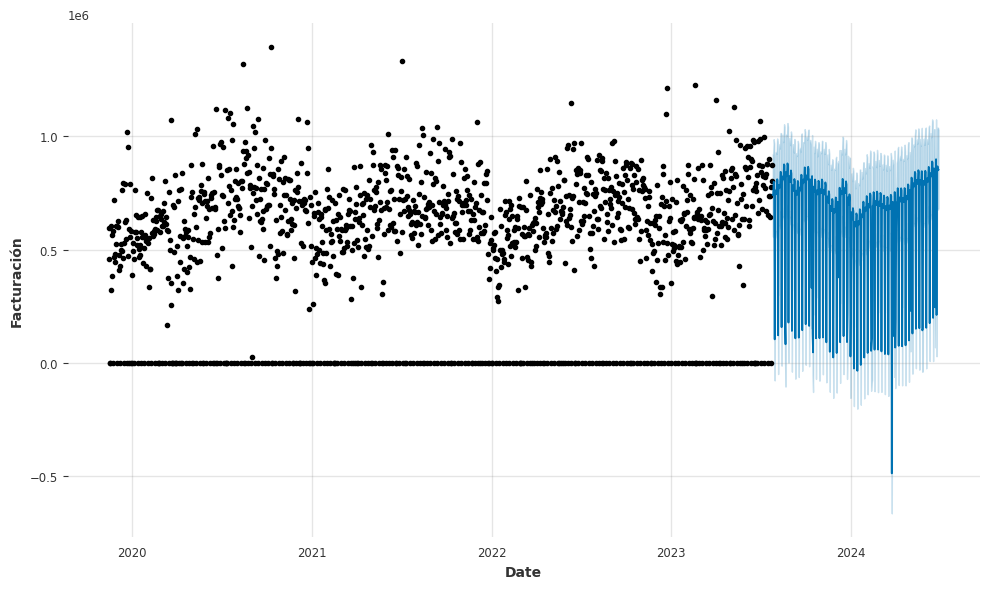

In [87]:
# Visualiza las predicciones
model.plot(forecast)
plt.xlabel('Date')
plt.ylabel('Facturación')
plt.show()

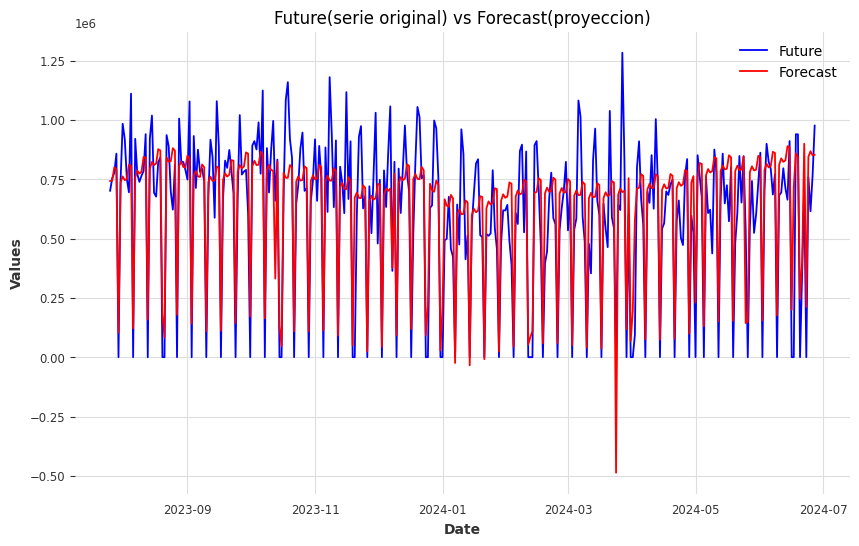

In [88]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.plot(testing_data['ds'], testing_data['y'], label='Future', color='blue')

plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Future(serie original) vs Forecast(proyeccion)')
plt.legend()

# gráfico
plt.show()

In [89]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Predecir en el conjunto de prueba
forecast_test = model.predict(testing_data)

# Extraer las predicciones y los valores reales
y_true = testing_data['y'].values
y_pred = forecast_test['yhat'].values

# Calcular MAE
mae = mean_absolute_error(y_true, y_pred)
print(f'MAE: {mae}')

# Calcular RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f'RMSE: {rmse}')

MAE: 136532.92300297823
RMSE: 172864.60202926825


###### Con más variables regresoras

In [30]:
display(df_vitalcer_daily)

,ds,y,dieta,RH2M,sube,ripte,indice_salarios,indice_salarios_registrado,indice_salarios_registrado_sector_privado,indice_salarios_registrado_sector_publico,...,lacteos,carnes,verduleria_fruteria,alimentos_preparados_rotiseria,articulos_limpieza_perfumeria,indumentaria_calzado_textiles_hogar,electronicos_articulos_hogar,otros,Visitas pagina,Alcance IG
0,2019-11-15,595695.03,62,66.94,3867.00,49574.33,239.44,243.40,246.54,238.13,...,7985919.66,8877286.12,2838731.67,883049.92,11316019.27,2197595.47,4638017.91,7726583.68,0.00,0.00
1,2019-11-16,460448.31,60,75.19,3867.00,49574.33,239.44,243.40,246.54,238.13,...,7985919.66,8877286.12,2838731.67,883049.92,11316019.27,2197595.47,4638017.91,7726583.68,0.00,0.00
2,2019-11-17,0.00,0,0.00,3867.00,49574.33,239.44,243.40,246.54,238.13,...,7985919.66,8877286.12,2838731.67,883049.92,11316019.27,2197595.47,4638017.91,7726583.68,0.00,0.00
3,2019-11-18,0.00,0,0.00,3867.00,49574.33,239.44,243.40,246.54,238.13,...,7985919.66,8877286.12,2838731.67,883049.92,11316019.27,2197595.47,4638017.91,7726583.68,0.00,0.00
4,2019-11-19,606252.48,88,73.75,3867.00,49574.33,239.44,243.40,246.54,238.13,...,7985919.66,8877286.12,2838731.67,883049.92,11316019.27,2197595.47,4638017.91,7726583.68,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1682,2024-06-23,0.00,0,0.00,7952.00,879483.08,4077.32,4490.03,4807.34,3957.89,...,170075429.10,153950342.70,60571949.32,13628091.52,207457595.60,34292093.85,65096403.31,85587417.60,10.00,4.00
1683,2024-06-24,758690.00,64,81.62,29191.00,879483.08,4077.32,4490.03,4807.34,3957.89,...,170075429.10,153950342.70,60571949.32,13628091.52,207457595.60,34292093.85,65096403.31,85587417.60,26.00,12.00
1684,2024-06-25,614865.00,64,85.44,28699.00,879483.08,4077.32,4490.03,4807.34,3957.89,...,170075429.10,153950342.70,60571949.32,13628091.52,207457595.60,34292093.85,65096403.31,85587417.60,25.00,15.00
1685,2024-06-26,765132.00,66,82.25,29018.00,879483.08,4077.32,4490.03,4807.34,3957.89,...,170075429.10,153950342.70,60571949.32,13628091.52,207457595.60,34292093.85,65096403.31,85587417.60,32.00,13.00


In [57]:
# Definir la proporción de entrenamiento
train_size = int(0.8 * len(df_vitalcer_daily))

# Obtener la fecha de corte basada en el tamaño del conjunto de entrenamiento
cutoff_date = df_vitalcer_daily['ds'].iloc[train_size]

# Asegúrate de que cutoff_date sea una fecha razonable
print(f"Fecha de corte: {cutoff_date}")

Fecha de corte: 2023-07-26 00:00:00


In [58]:
# Crear máscaras para dividir los datos
training_mask = df_vitalcer_daily['ds'] < cutoff_date
testing_mask = df_vitalcer_daily['ds'] >= cutoff_date

# Verificar cuántas filas hay en cada conjunto
print(f"Filas en training_data: {training_mask.sum()}")
print(f"Filas en testing_data: {testing_mask.sum()}")

Filas en training_data: 1349
Filas en testing_data: 338


In [59]:
# Dividir los datos
training_data = df_vitalcer_daily[training_mask]
testing_data = df_vitalcer_daily[testing_mask]

In [61]:
display(testing_data)

,ds,y,dieta,RH2M,sube,ripte,indice_salarios,indice_salarios_registrado,indice_salarios_registrado_sector_privado,indice_salarios_registrado_sector_publico,...,lacteos,carnes,verduleria_fruteria,alimentos_preparados_rotiseria,articulos_limpieza_perfumeria,indumentaria_calzado_textiles_hogar,electronicos_articulos_hogar,otros,Visitas pagina,Alcance IG
1349,2023-07-26,701182.69,57,79.31,24719.00,324997.28,1519.50,1626.33,1626.81,1625.51,...,57590719.18,57972927.71,22237936.15,5390522.29,67635005.26,11553819.39,32825550.24,37767243.45,29.00,12.00
1350,2023-07-27,754330.13,59,80.62,25688.00,324997.28,1519.50,1626.33,1626.81,1625.51,...,57786561.06,58267008.04,22343537.41,5408068.33,67879376.41,11454441.22,32807550.02,37952231.08,23.00,15.00
1351,2023-07-28,777013.58,51,79.62,27016.00,324997.28,1519.50,1626.33,1626.81,1625.51,...,57982402.94,58561088.36,22449138.66,5425614.37,68123747.56,11355063.06,32789549.80,38137218.71,30.00,27.00
1352,2023-07-29,857735.95,55,74.25,18244.00,324997.28,1519.50,1626.33,1626.81,1625.51,...,58178244.83,58855168.69,22554739.91,5443160.40,68368118.71,11255684.89,32771549.59,38322206.34,20.00,13.00
1353,2023-07-30,0.00,0,0.00,10625.00,324997.28,1519.50,1626.33,1626.81,1625.51,...,58374086.71,59149249.01,22660341.16,5460706.44,68612489.86,11156306.73,32753549.37,38507193.98,24.00,5.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1682,2024-06-23,0.00,0,0.00,7952.00,879483.08,4077.32,4490.03,4807.34,3957.89,...,170075429.10,153950342.70,60571949.32,13628091.52,207457595.60,34292093.85,65096403.31,85587417.60,10.00,4.00
1683,2024-06-24,758690.00,64,81.62,29191.00,879483.08,4077.32,4490.03,4807.34,3957.89,...,170075429.10,153950342.70,60571949.32,13628091.52,207457595.60,34292093.85,65096403.31,85587417.60,26.00,12.00
1684,2024-06-25,614865.00,64,85.44,28699.00,879483.08,4077.32,4490.03,4807.34,3957.89,...,170075429.10,153950342.70,60571949.32,13628091.52,207457595.60,34292093.85,65096403.31,85587417.60,25.00,15.00
1685,2024-06-26,765132.00,66,82.25,29018.00,879483.08,4077.32,4490.03,4807.34,3957.89,...,170075429.10,153950342.70,60571949.32,13628091.52,207457595.60,34292093.85,65096403.31,85587417.60,32.00,13.00


Dividimos entre train y test y creamos el modelo

In [62]:
from prophet.make_holidays import make_holidays_df

# Crear los días festivos de Argentina para los años que te interesen
holidays = make_holidays_df(year_list=[2019,2020,2021,2022,2023, 2024], country='AR')

In [63]:
# Ajuste del modelo Prophet con incorporación de días festivos y otros parámetros
model = Prophet(holidays=holidays)


# Agregar todos los regresores automáticamente
for col in training_data.columns:
    if col not in ['ds', 'y']:  # Excluye las columnas 'ds' (fecha) y 'y' (tu objetivo)
        model.add_regressor(col)

# Ajustar el modelo
model.fit(training_data)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3l7ja81k/8iuic8nj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3l7ja81k/l2_mibi7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80866', 'data', 'file=/tmp/tmp3l7ja81k/8iuic8nj.json', 'init=/tmp/tmp3l7ja81k/l2_mibi7.json', 'output', 'file=/tmp/tmp3l7ja81k/prophet_modeln8pbte05/prophet_model-20240817173520.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:35:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:35:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [64]:
# Predecir en el conjunto de prueba
forecast = model.predict(testing_data)

# Combinar las predicciones con el conjunto de prueba para comparar
testing_data['yhat'] = forecast['yhat']

In [65]:
display(forecast)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Alcance IG,Alcance IG_lower,Alcance IG_upper,Bridge Public Holiday,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-07-26,415096.38,548221.70,888310.66,415096.38,415096.38,4918.98,4918.98,4918.98,0.00,...,25201.85,25201.85,25201.85,37566.76,37566.76,37566.76,0.00,0.00,0.00,717849.09
1,2023-07-27,414866.34,576013.91,904562.15,414866.34,414866.34,6505.58,6505.58,6505.58,0.00,...,32100.22,32100.22,32100.22,34804.40,34804.40,34804.40,0.00,0.00,0.00,735890.56
2,2023-07-28,414636.29,616568.51,955782.94,414636.29,414636.29,12851.99,12851.99,12851.99,0.00,...,91065.28,91065.28,91065.28,32452.31,32452.31,32452.31,0.00,0.00,0.00,789043.51
3,2023-07-29,414406.25,601532.91,927455.88,414406.25,414406.25,5447.85,5447.85,5447.85,0.00,...,121808.71,121808.71,121808.71,30558.91,30558.91,30558.91,0.00,0.00,0.00,764781.48
4,2023-07-30,414176.20,-117903.63,229446.24,414176.20,414176.20,1216.91,1216.91,1216.91,0.00,...,-328383.79,-328383.79,-328383.79,29167.28,29167.28,29167.28,0.00,0.00,0.00,57869.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333,2024-06-23,338491.20,1153373.63,1477942.63,338491.18,338491.23,688.04,688.04,688.04,0.00,...,-328383.79,-328383.79,-328383.79,120804.67,120804.67,120804.67,0.00,0.00,0.00,1327036.27
334,2024-06-24,338261.16,1835645.43,2189556.10,338261.14,338261.18,4918.98,4918.98,4918.98,0.00,...,16139.46,16139.46,16139.46,121633.82,121633.82,121633.82,0.00,0.00,0.00,2016220.41
335,2024-06-25,338031.11,1872247.82,2221853.25,338031.09,338031.14,6505.58,6505.58,6505.58,0.00,...,42068.26,42068.26,42068.26,122090.34,122090.34,122090.34,0.00,0.00,0.00,2048394.57
336,2024-06-26,337801.07,1860366.67,2190143.32,337801.04,337801.09,5447.85,5447.85,5447.85,0.00,...,25201.85,25201.85,25201.85,122188.86,122188.86,122188.86,0.00,0.00,0.00,2026567.92


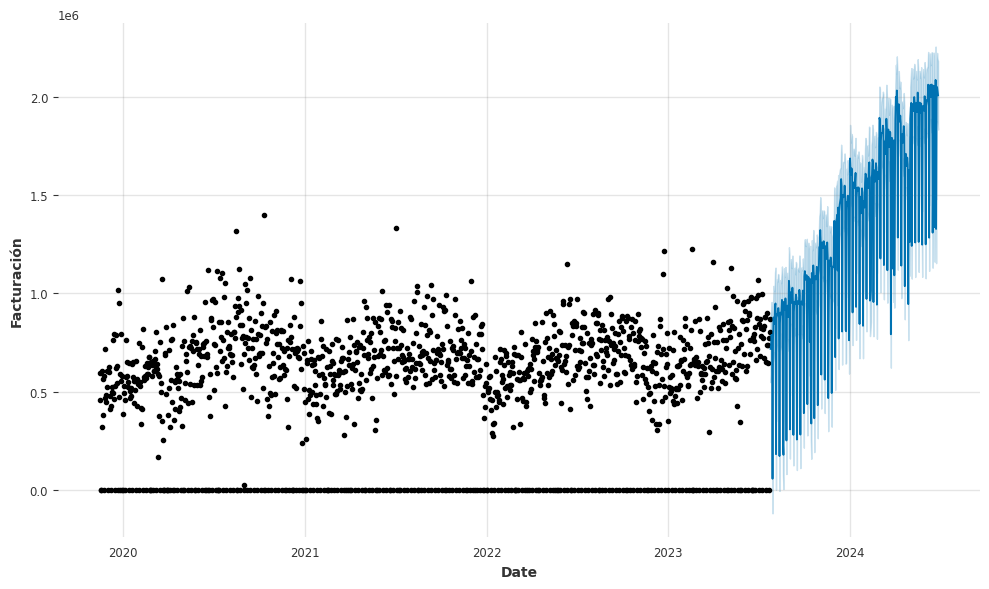

In [66]:
# Visualiza las predicciones
model.plot(forecast)
plt.xlabel('Date')
plt.ylabel('Facturación')
plt.show()

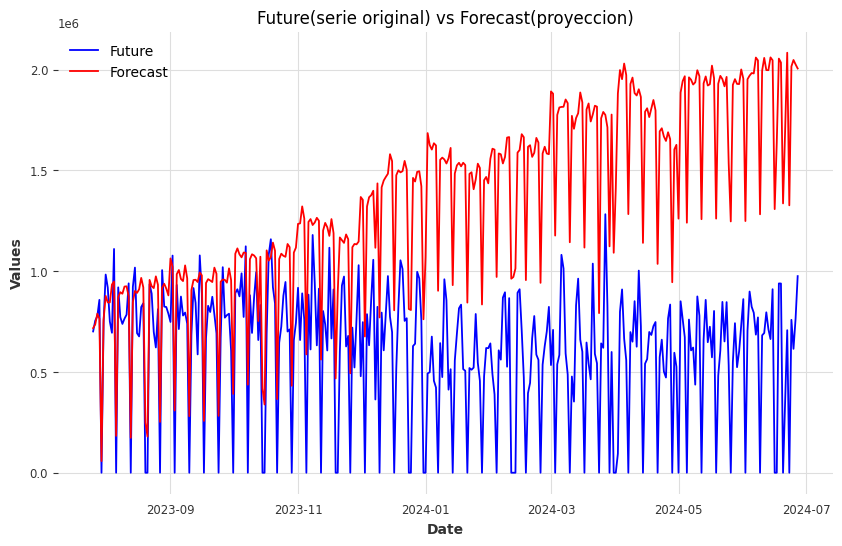

In [67]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.plot(testing_data['ds'], testing_data['y'], label='Future', color='blue')

plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Future(serie original) vs Forecast(proyeccion)')
plt.legend()

# gráfico
plt.show()

In [56]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Predecir en el conjunto de prueba
forecast_test = model.predict(testing_data)

# Extraer las predicciones y los valores reales
y_true = testing_data['y'].values
y_pred = forecast_test['yhat'].values

# Calcular MAE
mae = mean_absolute_error(y_true, y_pred)
print(f'MAE: {mae}')

# Calcular RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f'RMSE: {rmse}')

MAE: 883747.5054923306
RMSE: 1016706.7583438406


Con las variables regresoras más significativas de acuerdo al modelo AutoML

In [90]:
# Seleccionar las columnas que quieres mantener
columnas_a_incluir = ['ds', 'y', 'sube', 'RH2M', 'dieta', 'Ventas Minoristas', 'ventas_precios_constantes']

# Crear el nuevo DataFrame filtrado
df_vitalcer_filtered = df_vitalcer_daily[columnas_a_incluir].copy()

In [91]:
df_vitalcer_filtered.index = pd.to_datetime(df_vitalcer_filtered.index)

In [92]:
# Definir la proporción de entrenamiento
train_size = int(0.8 * len(df_vitalcer_filtered))

# Obtener la fecha de corte basada en el tamaño del conjunto de entrenamiento
cutoff_date = df_vitalcer_filtered['ds'].iloc[train_size]

# Asegúrate de que cutoff_date sea una fecha razonable
print(f"Fecha de corte: {cutoff_date}")

Fecha de corte: 2023-07-26 00:00:00


In [93]:
# Crear máscaras para dividir los datos
training_mask = df_vitalcer_filtered['ds'] < cutoff_date
testing_mask = df_vitalcer_filtered['ds'] >= cutoff_date

# Verificar cuántas filas hay en cada conjunto
print(f"Filas en training_data: {training_mask.sum()}")
print(f"Filas en testing_data: {testing_mask.sum()}")

Filas en training_data: 1349
Filas en testing_data: 338


In [94]:
# Dividir los datos
training_data = df_vitalcer_filtered[training_mask]
testing_data = df_vitalcer_filtered[testing_mask]

In [95]:
# Ajuste del modelo Prophet con incorporación de días festivos y otros parámetros
model = Prophet(holidays=holidays)


# Agregar todos los regresores automáticamente
for col in training_data.columns:
    if col not in ['ds', 'y']:  # Excluye las columnas 'ds' (fecha) y 'y' (tu objetivo)
        model.add_regressor(col)

# Ajustar el modelo
model.fit(training_data)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3l7ja81k/_hk_3pee.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3l7ja81k/ab_apfsi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14510', 'data', 'file=/tmp/tmp3l7ja81k/_hk_3pee.json', 'init=/tmp/tmp3l7ja81k/ab_apfsi.json', 'output', 'file=/tmp/tmp3l7ja81k/prophet_model10qbrzk0/prophet_model-20240817195208.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:52:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:52:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [96]:
# Predecir en el conjunto de prueba
forecast = model.predict(testing_data)

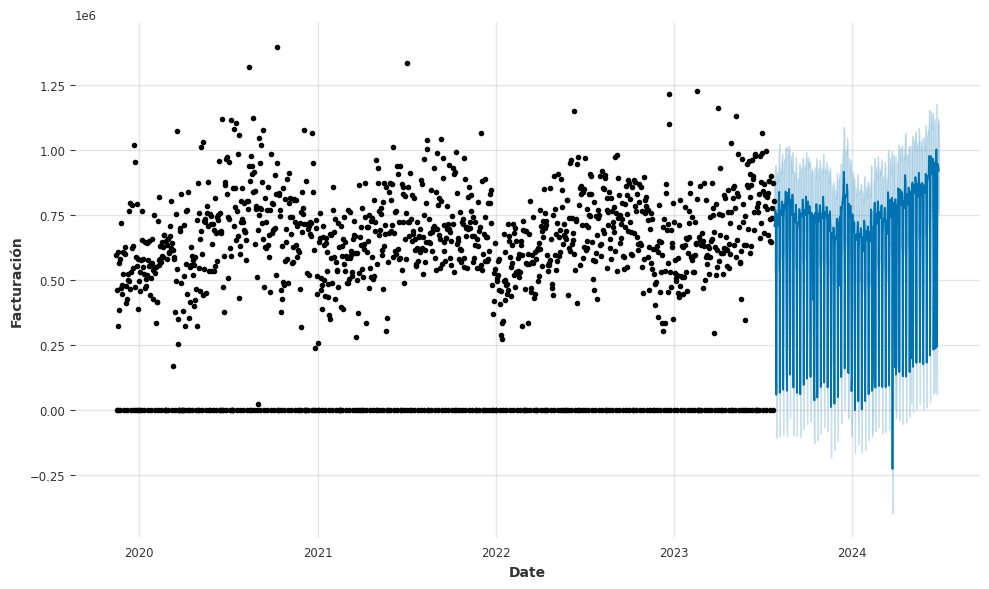

In [97]:
# Visualiza las predicciones
model.plot(forecast)
plt.xlabel('Date')
plt.ylabel('Facturación')
plt.show()

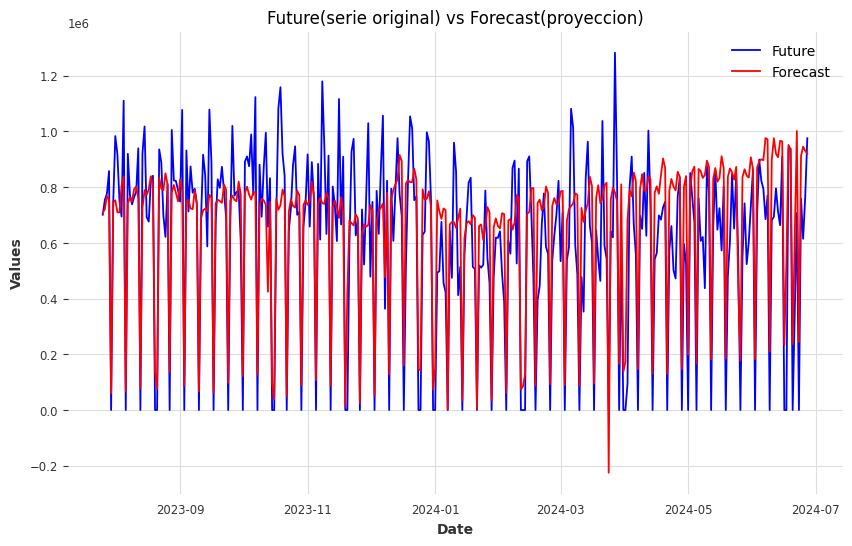

In [98]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.plot(testing_data['ds'], testing_data['y'], label='Future', color='blue')

plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Future(serie original) vs Forecast(proyeccion)')
plt.legend()

# gráfico
plt.show()

In [99]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Predecir en el conjunto de prueba
forecast_test = model.predict(testing_data)

# Extraer las predicciones y los valores reales
y_true = testing_data['y'].values
y_pred = forecast_test['yhat'].values

# Calcular MAE
mae = mean_absolute_error(y_true, y_pred)
print(f'MAE: {mae}')

# Calcular RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f'RMSE: {rmse}')

MAE: 148526.39747913397
RMSE: 180829.66275550946


##### **NeuralProphet**

NeuralProphet es una extensión de Prophet que integra conceptos de redes neuronales en el modelo de series temporales. Combina la descomposición clásica de Prophet con redes neuronales para mejorar la capacidad de modelado de patrones complejos.



In [100]:
import itertools
from datetime import timedelta
from sklearn.metrics import mean_squared_error

# NeuralProphet
!pip install neuralprophet[live] --quiet

from neuralprophet import NeuralProphet
from neuralprophet import set_random_seed

set_random_seed(0)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 51.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.8/145.8 kB 5.0 MB/s eta 0:00:00


ERROR:NP.plotly:Importing plotly failed. Interactive plots will not work.
ERROR:NP.plotly:Importing plotly failed. Interactive plots will not work.


In [125]:
# URL de la hoja de Google Sheets
sheet_url = "https://docs.google.com/spreadsheets/d/1OVJRz3bjcKnrTl62DdEbvJTrMlDYCLFmRILtqNJgTvs/edit?usp=sharing"

# Convertir la URL a un formato que pandas pueda leer
csv_url = sheet_url.replace('/edit?usp=sharing', '/export?format=csv')

# Leer los datos en un DataFrame de pandas
df_vitalcer = pd.read_csv(csv_url)

In [126]:
# Convertir la columna 'fecha' a datetime y establecerla como índice
df_vitalcer['fecha'] = pd.to_datetime(df_vitalcer['fecha'])
df_vitalcer.set_index('fecha', inplace=True)

In [127]:
# Convertir todas las columnas excepto el índice a tipo numérico
for col in df_vitalcer.columns:
    if df_vitalcer[col].dtype == 'object':
        df_vitalcer[col] = df_vitalcer[col].str.replace(',', '.')
        df_vitalcer[col] = pd.to_numeric(df_vitalcer[col], errors='coerce')

In [128]:
# Imputar valores nulos en las columnas 'Visitas pagina' y 'Alcance IG' con 0
df_vitalcer['Visitas pagina'].fillna(0, inplace=True)
df_vitalcer['Alcance IG'].fillna(0, inplace=True)

In [129]:
# Resamplea a una frecuencia diaria y llena los días faltantes con 0
df_vitalcer_daily = df_vitalcer.asfreq('D').fillna(0)

In [130]:
df_vitalcer_daily.rename(columns={'Monto_deflactado': 'y'}, inplace=True)

In [131]:
df_vitalcer_daily.reset_index(inplace=True)  # Conviértelo en una columna llamada 'index'

# Renombra la columna 'index' a 'ds'
df_vitalcer_daily.rename(columns={'fecha': 'ds'}, inplace=True)

In [132]:
# Suponiendo que tu DataFrame se llama df_vitalcer_daily y tiene las columnas 'ds' y 'y'
df = df_vitalcer_daily

# Dividir el DataFrame en conjuntos de entrenamiento y validación (80% entrenamiento, 20% validación)
train_size = int(len(df) * 0.8)
df_train = df.iloc[:train_size]
df_valid = df.iloc[train_size:]

In [109]:
display(df_train)

,ds,y,dieta,RH2M,sube,ripte,indice_salarios,indice_salarios_registrado,indice_salarios_registrado_sector_privado,indice_salarios_registrado_sector_publico,...,lacteos,carnes,verduleria_fruteria,alimentos_preparados_rotiseria,articulos_limpieza_perfumeria,indumentaria_calzado_textiles_hogar,electronicos_articulos_hogar,otros,Visitas pagina,Alcance IG
0,2019-11-15,595695.03,62,66.94,3867.00,49574.33,239.44,243.40,246.54,238.13,...,7985919.66,8877286.12,2838731.67,883049.92,11316019.27,2197595.47,4638017.91,7726583.68,0.00,0.00
1,2019-11-16,460448.31,60,75.19,3867.00,49574.33,239.44,243.40,246.54,238.13,...,7985919.66,8877286.12,2838731.67,883049.92,11316019.27,2197595.47,4638017.91,7726583.68,0.00,0.00
2,2019-11-17,0.00,0,0.00,3867.00,49574.33,239.44,243.40,246.54,238.13,...,7985919.66,8877286.12,2838731.67,883049.92,11316019.27,2197595.47,4638017.91,7726583.68,0.00,0.00
3,2019-11-18,0.00,0,0.00,3867.00,49574.33,239.44,243.40,246.54,238.13,...,7985919.66,8877286.12,2838731.67,883049.92,11316019.27,2197595.47,4638017.91,7726583.68,0.00,0.00
4,2019-11-19,606252.48,88,73.75,3867.00,49574.33,239.44,243.40,246.54,238.13,...,7985919.66,8877286.12,2838731.67,883049.92,11316019.27,2197595.47,4638017.91,7726583.68,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1344,2023-07-21,738015.41,49,84.81,25240.00,324997.28,1519.50,1626.33,1626.81,1625.51,...,56611509.77,56502526.09,21709929.89,5302792.12,66413149.51,12050710.21,32915551.34,36842305.28,37.00,44.00
1345,2023-07-22,775085.99,61,83.81,17693.00,324997.28,1519.50,1626.33,1626.81,1625.51,...,56807351.66,56796606.42,21815531.15,5320338.15,66657520.66,11951332.05,32897551.12,37027292.92,25.00,21.00
1346,2023-07-23,0.00,0,0.00,11885.00,324997.28,1519.50,1626.33,1626.81,1625.51,...,57003193.54,57090686.74,21921132.40,5337884.19,66901891.81,11851953.88,32879550.90,37212280.55,17.00,7.00
1347,2023-07-24,872060.27,64,78.31,23739.00,324997.28,1519.50,1626.33,1626.81,1625.51,...,57199035.42,57384767.06,22026733.65,5355430.22,67146262.96,11752575.72,32861550.68,37397268.18,42.00,17.00


Modelo con todas las variables regresoras

In [133]:

# Inicializar el modelo
m = NeuralProphet(
    epochs=50,
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True,
    learning_rate=0.01
)

# Añadir días festivos de Argentina
m.add_country_holidays(country_name='Argentina')

# Añadir regresores (variables adicionales)
for col in df_train.columns:
    if col not in ['ds', 'y']:
        m.add_future_regressor(name=col)

# Entrenar el modelo
metrics2 = m.fit(df=df_train, validation_df=df_valid, freq="D")

# Mostrar las métricas relevantes
print(metrics2[-1:])


WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.926% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.926% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

     MAE_val  RMSE_val  Loss_val  RegLoss_val  epoch  train_loss  reg_loss  \
49 567004.06 657749.50      0.47         0.00     49        0.02      0.00   

         MAE      RMSE  Loss  RegLoss  
49 100694.76 133696.11  0.02     0.00  


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.704% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.704% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.704% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.704% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column


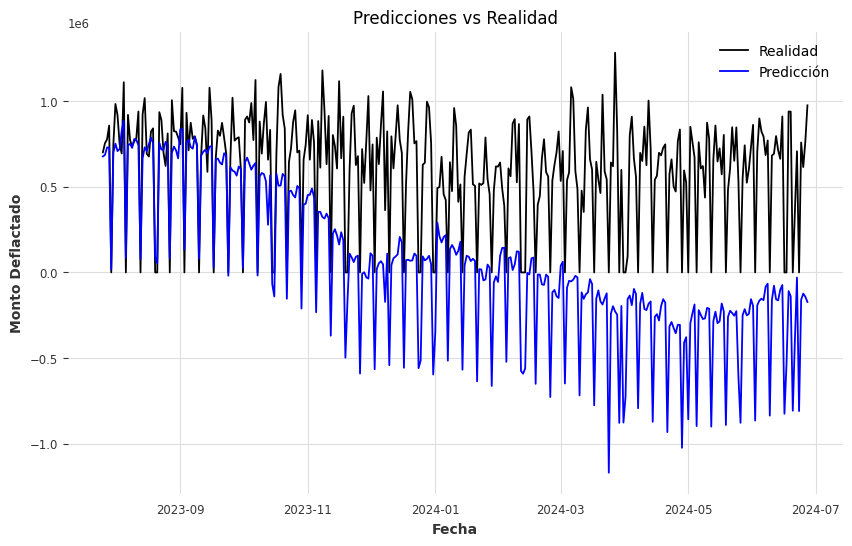

In [134]:
# Hacer predicciones para el conjunto de validación
future = df_valid.copy()
forecast = m.predict(df=future)

# Combinar predicciones con valores reales
forecast = forecast[['ds', 'yhat1']].merge(df_valid[['ds', 'y']], on='ds')

# Graficar las predicciones versus la realidad
plt.figure(figsize=(10, 6))
plt.plot(forecast['ds'], forecast['y'], label='Realidad', color='black')
plt.plot(forecast['ds'], forecast['yhat1'], label='Predicción', color='blue')
plt.xlabel('Fecha')
plt.ylabel('Monto Deflactado')
plt.title('Predicciones vs Realidad')
plt.legend()
plt.show()

Modelo simple

In [111]:
# Suponiendo que tu DataFrame se llama df_vitalcer_daily y tiene las columnas 'ds' y 'y'
df = df_vitalcer_daily[['ds', 'y']]

# Dividir el DataFrame en conjuntos de entrenamiento y validación (80% entrenamiento, 20% validación)
train_size = int(len(df) * 0.8)
df_train = df.iloc[:train_size]
df_valid = df.iloc[train_size:]

In [113]:
# Inicializar el modelo
m = NeuralProphet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True,
    epochs=50,
    learning_rate=0.01
)

# Añadir días festivos de Argentina
m.add_country_holidays(country_name='Argentina')

# Entrenar el modelo
metrics2 = m.fit(df=df_train, validation_df=df_valid, freq="D")

# Mostrar las métricas relevantes
print(metrics2[-1:])

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.926% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.926% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

     MAE_val  RMSE_val  Loss_val  RegLoss_val  epoch  train_loss  reg_loss  \
49 148572.83 183540.50      0.06         0.00     49        0.03      0.00   

         MAE      RMSE  Loss  RegLoss  
49 102774.53 136344.30  0.02     0.00  


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.704% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.704% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.704% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.704% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column


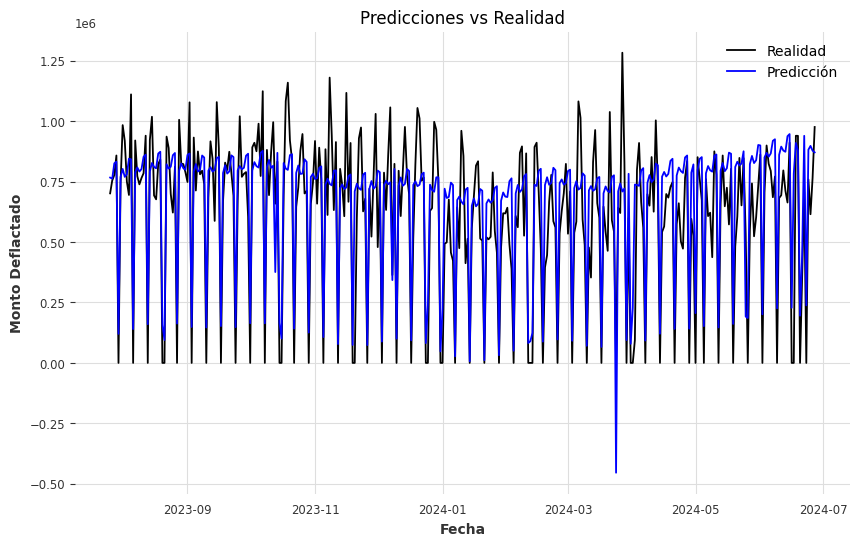

In [114]:
# Hacer predicciones para el conjunto de validación
future = df_valid.copy()
forecast = m.predict(df=future)

# Combinar predicciones con valores reales
forecast = forecast[['ds', 'yhat1']].merge(df_valid[['ds', 'y']], on='ds')

# Graficar las predicciones versus la realidad
plt.figure(figsize=(10, 6))
plt.plot(forecast['ds'], forecast['y'], label='Realidad', color='black')
plt.plot(forecast['ds'], forecast['yhat1'], label='Predicción', color='blue')
plt.xlabel('Fecha')
plt.ylabel('Monto Deflactado')
plt.title('Predicciones vs Realidad')
plt.legend()
plt.show()

Modelo son las variables más significativas de acuerdo a AutoML

In [115]:
# Seleccionar las columnas que quieres mantener
columnas_a_incluir = ['ds', 'y', 'sube', 'RH2M', 'dieta', 'Ventas Minoristas', 'ventas_precios_constantes']

# Crear el nuevo DataFrame filtrado
df_vitalcer_filtered = df_vitalcer_daily[columnas_a_incluir].copy()

In [116]:
# Suponiendo que tu DataFrame se llama df_vitalcer_daily y tiene las columnas 'ds' y 'y'
df = df_vitalcer_filtered

# Dividir el DataFrame en conjuntos de entrenamiento y validación (80% entrenamiento, 20% validación)
train_size = int(len(df) * 0.8)
df_train = df.iloc[:train_size]
df_valid = df.iloc[train_size:]

In [119]:
# Inicializar el modelo
m = NeuralProphet(
    epochs=50,
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True,
    learning_rate=0.01
)

# Añadir días festivos de Argentina
m.add_country_holidays(country_name='Argentina')

# Añadir regresores (variables adicionales)
for col in df_train.columns:
    if col not in ['ds', 'y']:
        m.add_future_regressor(name=col)

# Entrenar el modelo
metrics2 = m.fit(df=df_train, validation_df=df_valid, freq="D")

# Mostrar las métricas relevantes
print(metrics2[-1:])

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.926% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.926% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

     MAE_val  RMSE_val  Loss_val  RegLoss_val  epoch  train_loss  reg_loss  \
49 173308.00 206318.42      0.08         0.00     49        0.02      0.00   

         MAE      RMSE  Loss  RegLoss  
49 102832.23 135695.00  0.02     0.00  


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.704% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.704% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.704% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.704% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column


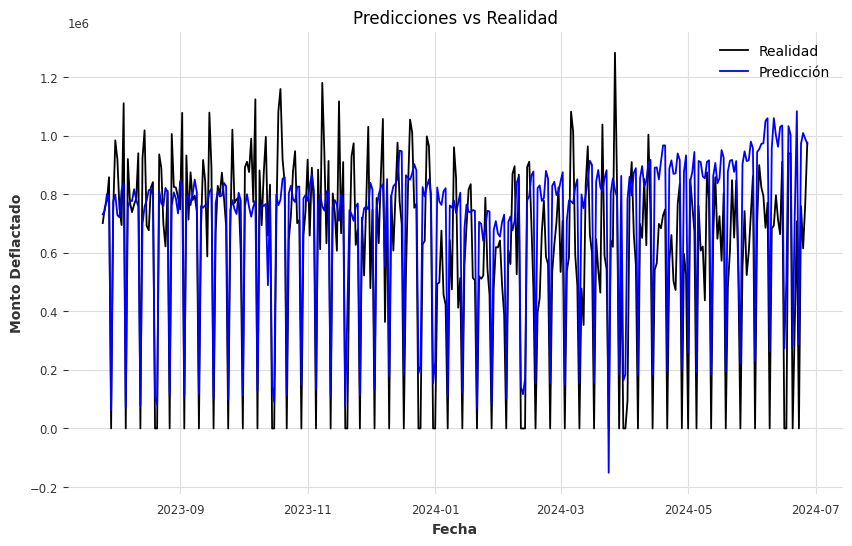

In [120]:
# Hacer predicciones para el conjunto de validación
future = df_valid.copy()
forecast = m.predict(df=future)

# Combinar predicciones con valores reales
forecast = forecast[['ds', 'yhat1']].merge(df_valid[['ds', 'y']], on='ds')

# Graficar las predicciones versus la realidad
plt.figure(figsize=(10, 6))
plt.plot(forecast['ds'], forecast['y'], label='Realidad', color='black')
plt.plot(forecast['ds'], forecast['yhat1'], label='Predicción', color='blue')
plt.xlabel('Fecha')
plt.ylabel('Monto Deflactado')
plt.title('Predicciones vs Realidad')
plt.legend()
plt.show()